## Resting-state epoch identification using K-means clustering on EEG/EMG derived PSD features

This notebook demonstrates how k-means clustering can be used to separate distinct types of epochs. Here, the goal was to identify
epochs that lie in between sleep and active states through from EEG (OFC_L) and EMG derived features.

Such an approach can nonetheless be used to basically separate many kind of distinct epochs, that is, if you can visually separate them
by eye when investigating a certain epoch's EMG and EEG signals.

In [109]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from mne.time_frequency import psd_array_multitaper

from settings import paths, quality_emg, freq_bands_eeg, freq_bands_emg

Let's define two functions that calculate features from either EEG or EMG signal traces

In [100]:
def calculate_emg_psd_features(signal, sfreq):
    psd, freq = psd_array_multitaper(signal, fmin=0, fmax=100, sfreq=sfreq, n_jobs=-1, verbose=False)

    psds = {}  # slice psd data of epoch based on the defined bands
    for band, (start, end) in freq_bands_emg.items():
        slice_start, slice_end = int(start / 100 * len(freq)), int(end / 100 * len(freq))
        psd_slice = psd[slice_start:slice_end]

        psds[f"EMG {band}"] = np.mean(np.log(psd_slice))

    psds['EMG high-low freq ratio'] = ((psds['EMG band9'] + psds['EMG band10']) / (psds['EMG band1'] + psds['EMG band2']))

    return psds

def calculate_eeg_psd_features(signal, sfreq):
    eeg_psds = {}
    for band, (start, end) in freq_bands_eeg.items():
        psd, freq = psd_array_multitaper(signal, fmin=start, fmax=end, sfreq=sfreq, n_jobs=-1)

        eeg_psds[f"OFC_L {band}"] = np.mean(np.log(psd))

    eeg_psds['gamma-delta ratio'] = (eeg_psds['OFC_L $\\gamma$'] / eeg_psds['OFC_L $\\delta$'])
    return eeg_psds

And then the general function that's used to engineer features for epoch clustering. 

In [277]:
def engineer_features(non_mov_epochs, wanted_chans):
    """
    Engineers desired features for the given subject. If there are two quality EMG channels,
    then the features derived from both EMG channels are averaged.

    :param non_mov_epochs: the subject's epochs
    :param wanted_chans: indexes used to retrieve right epoch data (one EEG channel, and one EMG channel)
    :return:
    """
    print(f'Engineering features..')

    sfreq = non_mov_epochs.info['sfreq']
    all_features = []  # list holding dict with all features per epoch

    # loop through the epochs in the subject's epochs
    for i, epoch in enumerate(non_mov_epochs):
        # features per epoch are stored in here
        features = {
            'subject_id': non_mov_epochs.metadata['animal_id'].iloc[0],
            'epoch_n': non_mov_epochs.metadata.iloc[i].name,
            'movement': non_mov_epochs.metadata["movement"].iloc[i],
            'frame_start_end': non_mov_epochs.metadata["epochs_start_end_frames"].iloc[i]
        }

        # for all wanted_chans, calculate the desired features
        for chan_type, chan_index in wanted_chans.items():
            if chan_type == 'EEG':
                # we only wish to calc PSD features using one chan, so get first index and then the data
                eeg_chan_data = epoch[chan_index, :]

                # get eeg psd features with right data from epoch
                features.update(calculate_eeg_psd_features(eeg_chan_data, sfreq))

            # if the looped channel type we need to calc features for is EMG, then we end up here
            if chan_type == 'EMG':

                # if there's only one EMG channel, save its features
                channel_data = epoch[chan_index, :]
                features.update(calculate_emg_psd_features(channel_data, sfreq))

        # store this epoch's features in the list
        all_features.append(features)

    print(f'Done engineering features.')

    return pd.DataFrame(all_features)

A function that retrieves the channel names that we want to engineer features for.

In [102]:
def get_wanted_chans(subject_epochs, subject_id):
    wanted_eeg_chan = 'OFC_L'
    wanted_emg_chan = quality_emg[int(subject_id)]
    recorded_chans = subject_epochs.info['ch_names']
    wanted_chan_indexes = {
        'EEG': [index for index, value in enumerate(recorded_chans) if value == wanted_eeg_chan][0],
        'EMG': [index for index, value in enumerate(recorded_chans) if value == wanted_emg_chan][0]
    }
    return wanted_chan_indexes

A function that uses DBSCAN for outlier/anomaly removal. Uses a hard-coded cutoff for the amount of epochs needed. Change the DBSCAN arguments to your liking.

In [256]:
def remove_cluster_outliers(df_numeric, df_plot):
    # hard-coded cutoff for animals that already have a relatively low amount of epochs
    if df_numeric.shape[0] < 400:
        return df_numeric, df_plot

    dbscan = DBSCAN(eps=2.4, min_samples=35)
    outlier_preds = dbscan.fit_predict(df_numeric)

    df_plot['outlier'] = outlier_preds
    print("Number of outliers: ", len(outlier_preds[outlier_preds == -1]))
    
    # show outliers
    fig = plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_plot, x=0, y=1, hue="outlier", palette=sns.color_palette("husl"))
    plt.title("Clusters by PCA components, non-movement epochs")
    plt.xlabel("Principle Component 1")
    plt.ylabel("Principle Component 2")
    plt.show()
    
    # remove outliers
    df_numeric_wo_outliers = df_numeric[~df_plot['outlier'].isin([-1])]
    df_plot_wo_anomalies = df_plot[~df_plot['outlier'].isin([-1])]

    return df_numeric_wo_outliers, df_plot_wo_anomalies

And a plotting function to get handy insights into what kind of epochs each cluster holds.

In [301]:
def plot_cluster_insights(features, df_plot):
    
    clusters = np.unique(df_plot["cluster"])
    row_len = int(np.ceil(len(clusters) / 2)) + 1
    col_len = int(np.ceil(len(clusters) / row_len)) + 1
    palette = sns.color_palette("husl", 3).as_hex()
    
    # CREATE PLOTTING GRID USING PLOTLY
    
    fig = make_subplots(
        rows=row_len, cols=col_len,
        specs=[[{'type': 'polar'}, {'type': 'polar'}], [{'type': 'polar'}, {'type': 'scatter'}], [{"colspan": 2}, None]],
        horizontal_spacing=0.08, vertical_spacing=0.12,
        shared_yaxes=True, shared_xaxes=True,
        subplot_titles=["Cluster 0", "Cluster 1", "Cluster 2", "Clusters by PCA components, non-movement epochs", "Boxplot of (min-max scaled) feature distribution per cluster"]
    )
    
    # LOOP THROUGH CLUSTERS AND GENERATE RADAR PLOTS AND BOX-PLOTS
    
    cluster_info, max_value = {}, 0
    fig_box = go.Figure()  # for storing boxplot per cluster
    
    for i, cluster in enumerate(clusters):
        cluster_features = features[df_plot["cluster"] == cluster]
        cluster_features = cluster_features.drop(columns=['gamma-delta ratio', 'EMG high-low freq ratio'])
        
        row, col = (i // 2) + 1, (i % 2) + 1

        average_features = cluster_features.mean(axis=0)
        cluster_info[i] = average_features
        
        max_value = np.max(average_features) if np.max(average_features) > max_value else max_value
            
        fig.add_trace(go.Scatterpolar(
            r=average_features,
            theta=average_features.index,
            fill='toself',
            name=f'Cluster {i}',
            showlegend=False
        ), row=row, col=col)
        
        # add boxplot trace for this cluster as well
        cluster_features = cluster_features.drop(columns=['EMG band3', 'EMG band4', 'EMG band5', 'EMG band6', 'EMG band7', 'EMG band8'])
        repeated_arrays = [np.repeat(feature, len(cluster_features)) for feature in cluster_features.columns]
        x = np.concatenate(repeated_arrays)
        y = cluster_features.T.stack().values
        
        # per add_trace alle data van 1 cluster en splits het dmv de x op features
        fig_box.add_trace(go.Violin(
            y=y,
            x=x,
            name=f'Cluster {cluster}',
            marker_color=palette[cluster],
            showlegend=True
        ))

    fig_box.update_traces(box_visible=True, meanline_visible=True)
    # add the boxplot to the grid plot
    for trace in fig_box.data:
        fig.add_trace(trace, row=3, col=1)
    
    
    # ADD CLUSTER PLOT TO ROW 2 COL 2 OF GRID
    
    fig.add_trace(go.Scatter(
        x=df_plot[0], y=df_plot[1], mode="markers", 
        marker=dict(color=df_plot["cluster"], colorscale=palette),
        showlegend=False
    ), row=2, col=2)
    fig.update_xaxes(title_text="Principle Component 1", row=2, col=2)
    fig.update_yaxes(title_text="Principle Component 2", row=2, col=2)

    # COMPLETE FIGURE
    fig.update_layout(
        height=400*row_len, width=620*col_len,
        margin=dict(l=50, r=50, t=140, b=70),
        colorway=palette,
        showlegend=True,
        violinmode='group',
        violingap=0.3,
        violingroupgap=0.1
    )
    fig.update_annotations(yshift=20)
    fig.update_polars(radialaxis=dict(range=[0, max_value+.05]))
    fig.show()
    
    return cluster_info

## Epoch clustering for subject 39508 (WT)

In [94]:
epochs_39508 = mne.read_epochs(os.path.join(paths["epochs_folder"], "filtered_epochs_w_movement_39508-epo.fif"), preload=True)
epochs_39508 = epochs_39508[:-1]  # somehow the last epoch holds only zeros
epochs_39508.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,3207
Events,1: 3207
Time range,0.000 – 4.999 s
Baseline,off


In [105]:
non_mov_39508 = epochs_39508[epochs_39508.metadata['movement'] == 0]
features_39508 = engineer_features(non_mov_39508, get_wanted_chans(epochs_39508, '39508'))

Engineering features..
Done engineering features.


In [260]:
df_numeric = features_39508.iloc[:, 4:]
print(df_numeric.shape)
df_numeric.head()

(389, 17)


,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-13.580723,-14.346173,-14.237211,-16.844413,-17.501651,1.288713,-15.811422,-17.162293,-17.862393,-18.361798,-17.911074,-18.545229,-18.342799,-18.454851,-18.705182,-18.482485,1.127797
1,-12.708286,-13.251085,-14.909869,-16.759986,-17.782877,1.399314,-15.514908,-17.704031,-18.060586,-18.438066,-18.461283,-18.942014,-18.462417,-18.477012,-18.805324,-18.529427,1.123900
2,-13.000937,-12.513695,-15.146621,-16.703464,-17.720422,1.363011,-15.768436,-17.776696,-18.680256,-18.534022,-19.039441,-19.168212,-18.920294,-19.408564,-19.495606,-19.115775,1.151028
3,-12.857127,-13.332727,-14.892472,-16.905170,-17.745892,1.380238,-15.666305,-17.603781,-17.672099,-18.210353,-17.994014,-18.625255,-18.566366,-18.706818,-18.830411,-18.501657,1.122091
4,-12.809237,-13.280218,-14.513769,-16.761566,-17.275025,1.348638,-15.376889,-17.518799,-18.421073,-18.629621,-18.237068,-18.770884,-18.809124,-18.704513,-18.917884,-18.843330,1.147908


In [261]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
df_plot = pd.concat([features_39508.reset_index(drop=True), pd.DataFrame(comp)], axis=1)

### Anomaly detection using IsolationForest

In [262]:
df_numeric, df_plot = remove_cluster_outliers(df_numeric, df_plot)
print(df_plot.shape, df_numeric.shape)
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)

(389, 23) (389, 17)


In [263]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)

print(f'Clusters with sizes of: {np.unique(kmeans.labels_, return_counts=True)[1]}')
df_plot["cluster"] = kmeans.labels_

Clusters with sizes of: [211  26 152]


### Show cluster insights

In [302]:
cluster_info = plot_cluster_insights(scaled_features, df_plot)

ValueError: 
    Invalid value of type 'builtins.float' received for the 'y' property of layout.title
        Received value: -0.01

    The 'y' property is a number and may be specified as:
      - An int or float in the interval [0, 1]

In [265]:
average_emgs = {}
cluster_gammas = {}
for cluster_n, info in cluster_info.items():
    average_emgs[cluster_n] = np.mean(info[5:])
    cluster_gammas[cluster_n] = info['OFC_L $\gamma$']

highest_av_emg_cluster = max(average_emgs, key=average_emgs.get)
highest_gamma_cluster = max(cluster_gammas, key=cluster_gammas.get)

for cluster_n, info in cluster_info.items():
    
    if (cluster_n == highest_av_emg_cluster) & (cluster_n == highest_gamma_cluster):
        print(f'Cluster {highest_av_emg_cluster} is likely active') 
    elif (info['OFC_L $\gamma$'] < info['OFC_L $\delta$']) & ((info['EMG band10'] + info['EMG band9']) < (info['EMG band1'] + info['EMG band2'])):
        print(f'Cluster {cluster_n} is likely sleep')
    else:
        print(f'Cluster {cluster_n} is likely resting (or something else)')

Cluster 0 is likely sleep
Cluster 1 is likely resting (or something else)
Cluster 2 is likely active


## Epoch clustering for subject 80625 (KO)

In [176]:
epochs_80625 = mne.read_epochs(os.path.join(paths["epochs_folder"], "filtered_epochs_w_movement_80625-epo.fif"), preload=True)
epochs_80625 = epochs_80625[:-1]  # somehow the last epoch holds only zeros
epochs_80625.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,1544
Events,1: 1544
Time range,0.000 – 4.999 s
Baseline,off


In [177]:
non_mov_80625 = epochs_80625[epochs_80625.metadata['movement'] == 0]
features_80625 = engineer_features(non_mov_80625, get_wanted_chans(epochs_80625, '80625'))

Engineering features..
Done engineering features.


In [266]:
df_numeric = features_80625.iloc[:, 4:]
print(df_numeric.shape)
df_numeric.head()

(898, 17)


,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-15.826677,-16.365108,-15.946520,-18.029519,-18.899249,1.194139,-16.069324,-17.425135,-18.056118,-18.119496,-18.151192,-18.683983,-18.698573,-18.501623,-18.583025,-17.946377,1.090610
1,-15.567960,-15.691947,-16.063244,-17.421022,-18.753765,1.204639,-15.709721,-17.559035,-18.094597,-18.470368,-18.513797,-18.823047,-18.310157,-18.697271,-18.707440,-18.529400,1.119274
2,-15.047281,-15.192003,-16.372403,-17.978878,-18.718807,1.243999,-15.899201,-17.709568,-18.518964,-18.347886,-18.781456,-18.906762,-18.420800,-18.558848,-18.659125,-18.659062,1.110371
3,-15.477481,-15.116941,-16.414383,-17.502805,-18.703929,1.208461,-16.045884,-17.603680,-18.338061,-18.568886,-19.059590,-19.078569,-18.733511,-18.803696,-18.719771,-18.948368,1.119424
4,-15.571145,-15.174178,-15.867502,-17.701516,-18.704417,1.201223,-15.910047,-17.834114,-18.429282,-18.390033,-18.463950,-18.517219,-18.528908,-18.796042,-18.943453,-18.633807,1.113593


In [267]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
df_plot = pd.concat([features_80625.reset_index(drop=True), pd.DataFrame(comp)], axis=1)

### Anomaly detection using DBSCAN

Number of outliers:  6


/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_8078/3974503005.py:11: UserWarning:

The palette list has more values (6) than needed (2), which may not be intended.



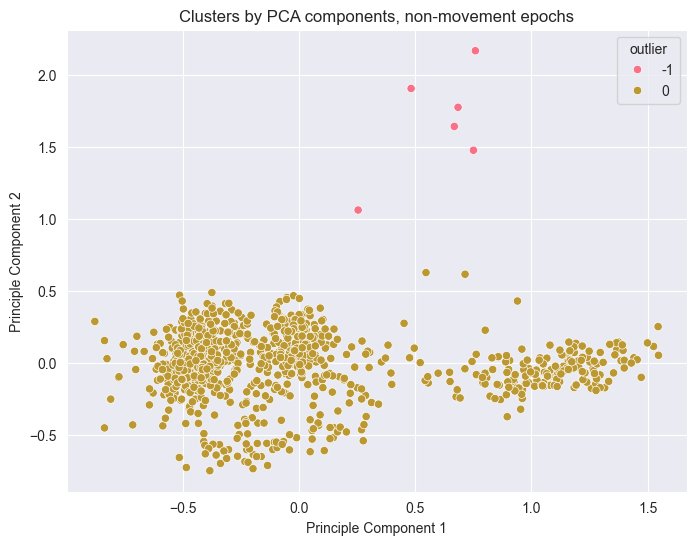

(892, 24) (892, 17)


In [246]:
df_numeric, df_plot = remove_cluster_outliers(df_numeric, df_plot)
print(df_plot.shape, df_numeric.shape)
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)

In [247]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)

print(f'Clusters with sizes of: {np.unique(kmeans.labels_, return_counts=True)[1]}')
df_plot["cluster"] = kmeans.labels_

Clusters with sizes of: [598 168 126]


### Show cluster insights

In [248]:
cluster_info = plot_cluster_insights(scaled_features, df_plot)

In [213]:
average_emgs = {}
cluster_gammas = {}
for cluster_n, info in cluster_info.items():
    average_emgs[cluster_n] = np.mean(info[5:])
    cluster_gammas[cluster_n] = info['OFC_L $\gamma$']

highest_av_emg_cluster = max(average_emgs, key=average_emgs.get)
highest_gamma_cluster = max(cluster_gammas, key=cluster_gammas.get)

for cluster_n, info in cluster_info.items():
    
    if (cluster_n == highest_av_emg_cluster) & (cluster_n == highest_gamma_cluster):
        print(f'Cluster {highest_av_emg_cluster} is likely active') 
    elif (info['OFC_L $\gamma$'] < info['OFC_L $\delta$']) & ((info['EMG band10'] + info['EMG band9']) < (info['EMG band1'] + info['EMG band2'])):
        print(f'Cluster {cluster_n} is likely sleep')
    else:
        print(f'Cluster {cluster_n} is likely resting (or something else)')

Cluster 0 is likely sleep
Cluster 1 is likely active
Cluster 2 is likely resting (or something else)


## Epoch clustering for subject 79602 (WT)

In [303]:
epochs_79602 = mne.read_epochs(os.path.join(paths["epochs_folder"], "filtered_epochs_w_movement_79602-epo.fif"), preload=True)
epochs_79602 = epochs_79602[:-1]  # somehow the last epoch holds only zeros
epochs_79602.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,3050
Events,1: 3050
Time range,0.000 – 4.999 s
Baseline,off


In [304]:
non_mov_79602 = epochs_79602[epochs_79602.metadata['movement'] == 0]
features_79602 = engineer_features(non_mov_79602, get_wanted_chans(epochs_79602, '79602'))

Engineering features..
Done engineering features.


In [305]:
df_numeric = features_79602.iloc[:, 4:]
print(df_numeric.shape)
df_numeric.head()

(614, 17)


,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-13.454676,-12.964446,-14.419840,-16.793435,-17.645603,1.311485,-15.884278,-17.430349,-17.754259,-17.945781,-18.173068,-18.599857,-18.915776,-18.755629,-19.082144,-18.986367,1.142697
1,-13.293052,-13.950133,-13.881056,-16.837383,-17.361049,1.306024,-15.734149,-17.421627,-18.065276,-17.997148,-17.573040,-18.271510,-18.719836,-18.771765,-18.779137,-18.911567,1.136776
2,-13.161084,-12.900051,-14.338678,-16.780541,-17.535354,1.332364,-15.587428,-17.641862,-18.043255,-18.090677,-17.985102,-18.442812,-18.203042,-18.987113,-18.967506,-18.977530,1.141915
3,-13.654374,-14.553821,-13.740323,-16.936793,-17.286539,1.266007,-15.804059,-17.022455,-17.126551,-17.071565,-17.406413,-17.873255,-17.413785,-17.657101,-18.171353,-18.274364,1.110252
4,-13.391768,-14.264439,-13.913758,-17.133251,-17.600925,1.314309,-15.867851,-17.663962,-18.151790,-17.803347,-18.113021,-18.579428,-18.386750,-18.579616,-18.739582,-18.629629,1.114441


In [270]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
df_plot = pd.concat([features_79602.reset_index(drop=True), pd.DataFrame(comp)], axis=1)

### Anomaly detection using DBSCAN

Number of outliers:  41


/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_8078/3960416708.py:14: UserWarning:

The palette list has more values (6) than needed (2), which may not be intended.



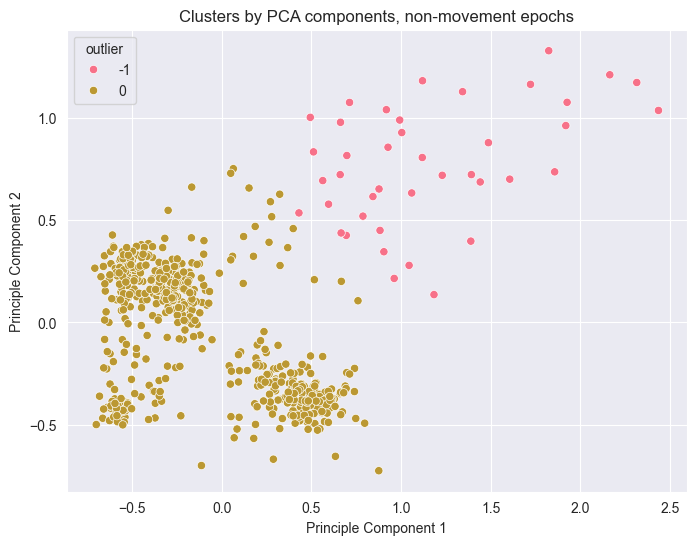

(573, 24) (573, 17)


In [271]:
df_numeric, df_plot = remove_cluster_outliers(df_numeric, df_plot)
print(df_plot.shape, df_numeric.shape)
scaler = MinMaxScaler().set_output(transform="pandas")
scaled_features = scaler.fit_transform(df_numeric)

In [272]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)

print(f'Clusters with sizes of: {np.unique(kmeans.labels_, return_counts=True)[1]}')
df_plot["cluster"] = kmeans.labels_

Clusters with sizes of: [ 66 207 300]


### Show cluster insights

In [273]:
cluster_info = plot_cluster_insights(scaled_features, df_plot)

In [274]:
average_emgs = {}
cluster_gammas = {}
for cluster_n, info in cluster_info.items():
    average_emgs[cluster_n] = np.mean(info[5:])
    cluster_gammas[cluster_n] = info['OFC_L $\gamma$']

highest_av_emg_cluster = max(average_emgs, key=average_emgs.get)
highest_gamma_cluster = max(cluster_gammas, key=cluster_gammas.get)

for cluster_n, info in cluster_info.items():
    
    if (cluster_n == highest_av_emg_cluster) & (cluster_n == highest_gamma_cluster):
        print(f'Cluster {highest_av_emg_cluster} is likely active') 
    elif (info['OFC_L $\gamma$'] < info['OFC_L $\delta$']) & ((info['EMG band10'] + info['EMG band9']) < (info['EMG band1'] + info['EMG band2'])):
        print(f'Cluster {cluster_n} is likely sleep')
    else:
        print(f'Cluster {cluster_n} is likely resting (or something else)')

Cluster 0 is likely resting (or something else)
Cluster 1 is likely active
Cluster 2 is likely sleep


## Active vs Sleep vs Rest epochs

For reference; let's take a look at a perfect example of active/sleep/resting separation. By eye you can clearly distinguish the three. Sleep has low gamma waves in the OFC, and low frequency waves in the EMG signal. Active state (grooming or eating etc.) is the best distinguishable as it has clearly very high EMG, as well as a lot of gamma waves in the OFC signal. The resting state has slow but large waves in the OFC, and a EMG signal that seems to be in between Active and Sleep when it comes to frequencies. 

39508 epoch 231: active 
39508 epoch 2846: sleep 
39508 epoch 3052: resting 


In [146]:
epoch_active = epochs_39508[231]
epoch_sleep = epochs_39508[2846]
epoch_resting = epochs_39508[3052]

OFC_L Signal

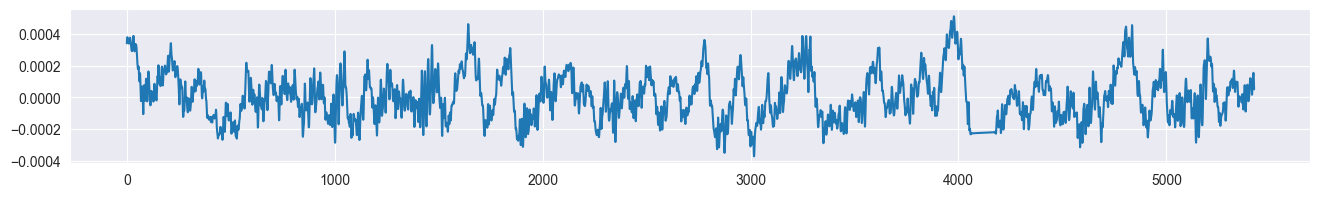

Relative power in band $\delta$: 0.3577681200688263
Relative power in band $\theta$: 0.2883146217199913
Relative power in band $\alpha$: 0.1291456106834329
Relative power in band $\beta$: 0.047327886351424424
Relative power in band $\gamma$: 0.11301209738843704
delta to alpha rel. ratio: 2.7702692966143654
theta to beta rel. ratio: 6.091855012902217


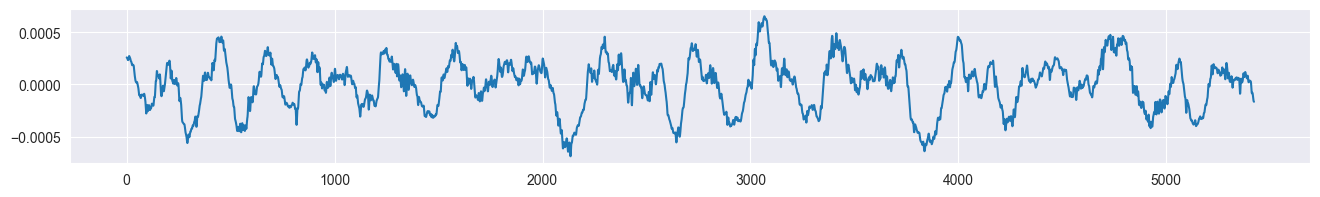

Relative power in band $\delta$: 0.512755734018567
Relative power in band $\theta$: 0.3080611745120708
Relative power in band $\alpha$: 0.04285217392439587
Relative power in band $\beta$: 0.028203173964435908
Relative power in band $\gamma$: 0.01524043290647067
delta to alpha rel. ratio: 11.96568778338346
theta to beta rel. ratio: 10.92292572816573


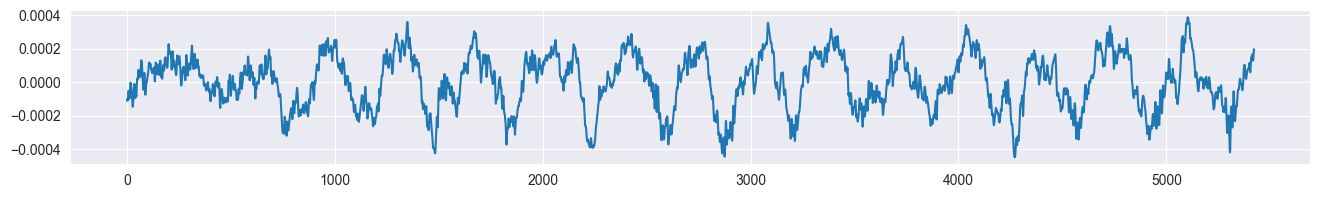

Relative power in band $\delta$: 0.6797441097707284
Relative power in band $\theta$: 0.0990133458948118
Relative power in band $\alpha$: 0.0762009525406809
Relative power in band $\beta$: 0.03883373466533591
Relative power in band $\gamma$: 0.03473678657580431
delta to alpha rel. ratio: 8.920414864995786
theta to beta rel. ratio: 2.549673544100148


In [285]:
for epoch in [epoch_active, epoch_sleep, epoch_resting]:
    fig = plt.figure(figsize=(16,2))
    signal = epoch.get_data(picks='OFC_L')[0,0,:]
    plt.plot(signal)
    plt.show()
    
    # relative power caluclations
    psd, freq = psd_array_multitaper(signal, fmin=0, fmax=100, sfreq=epoch.info['sfreq'], n_jobs=-1, verbose=False)

    # Compute total power
    total_power = np.trapz(psd, freq)
    rel_powers = {}
    powers = {}
    for band, (start, end) in freq_bands_eeg.items():
        slices = (freq >= start) & (freq <= end)
        power = np.trapz(psd[slices], freq[slices])
        rel_power = power/total_power
        rel_powers[band] = rel_power
        
        print(f"Relative power in band {band}: {rel_power}")
    print('delta to alpha rel. ratio:', rel_powers[r"$\delta$"] / rel_powers[r"$\alpha$"])

What we notice here is, that we might have to sum the relative powers in delta and theta in order to get a good separation between sleep and resting. The Gamma band seems to be very important to separate active from sleep and resting.

EMG Signal

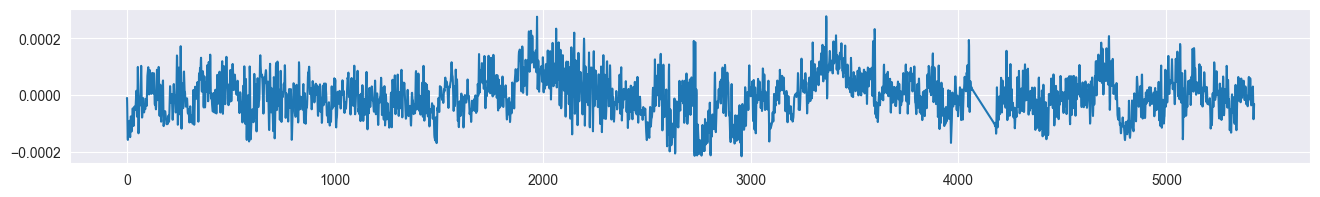

Hjorth Mobility:  0.4381286444267385
Hjorth Complexity:  1.915123122427399
Relative power in band $\delta$: 0.21232877870464123
Relative power in band $\theta$: 0.1888245802484861
Relative power in band $\alpha$: 0.0898979661361992
Relative power in band $\beta$: 0.08243707167744868
Relative power in band $\gamma$: 0.20163939011147078


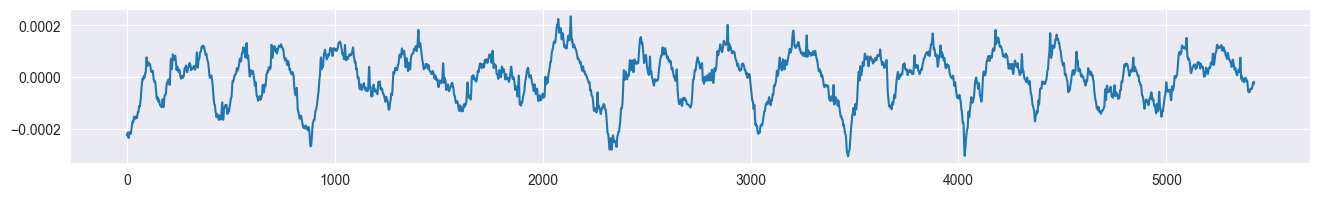

Hjorth Mobility:  0.07432769973251814
Hjorth Complexity:  8.147077304671138
Relative power in band $\delta$: 0.6209605313237635
Relative power in band $\theta$: 0.21214978307059892
Relative power in band $\alpha$: 0.06247780721183787
Relative power in band $\beta$: 0.03396214371806276
Relative power in band $\gamma$: 0.01803593752643849


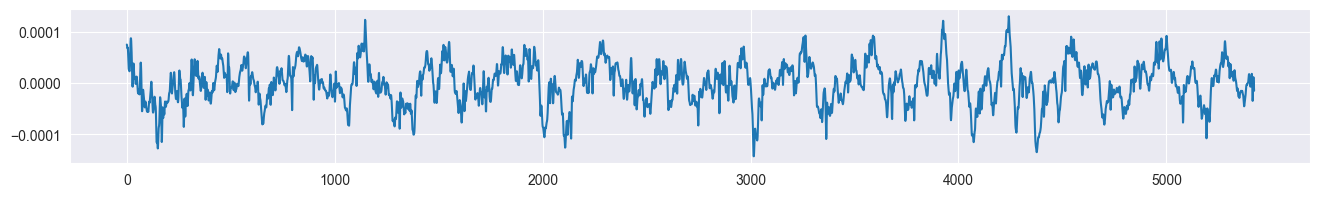

Hjorth Mobility:  0.16163443343681205
Hjorth Complexity:  4.045681071176808
Relative power in band $\delta$: 0.39775650659393
Relative power in band $\theta$: 0.08931444592836167
Relative power in band $\alpha$: 0.28604048495627865
Relative power in band $\beta$: 0.09064577804298646
Relative power in band $\gamma$: 0.08246641484591463


In [333]:
freq_bands_emg = {
    'band1': (0, 50), 'band2': (50, 100)
}
for epoch in [epoch_active, epoch_sleep, epoch_resting]:
    fig = plt.figure(figsize=(16,2))
    signal = epoch.get_data(picks='EMG_L')[0,0,:]
    plt.plot(signal)
    plt.show()
    
    # relative power caluclations
    psd, freq = psd_array_multitaper(signal, fmin=0, fmax=100, sfreq=epoch.info['sfreq'], n_jobs=-1, verbose=False)
    
    diff1 = np.diff(signal)
    var_diff1 = np.var(diff1)
    var_signal = np.var(signal)
    mobility = np.sqrt(var_diff1 / var_signal)
    print("Hjorth Mobility: ", mobility)
    
    diff2 = np.diff(signal, 2)
    var_diff2 = np.var(diff2)
    complexity = np.sqrt(var_diff2 / var_diff1) / np.sqrt(var_diff1 / var_signal)
    print("Hjorth Complexity: ", complexity)
        
    total_power = np.trapz(psd, freq)
    
    for band, (start, end) in freq_bands_eeg.items():
        slices = (freq >= start) & (freq <= end)
        power = np.trapz(psd[slices], freq[slices])
        rel_power = power/total_power
        print(f"Relative power in band {band}: {rel_power}")

Especially bands 1 and 2 seem very important here. It might be good to sum bands 3 through 9.